In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
from monai.data import CacheDataset, Dataset, list_data_collate
from monai.transforms import (
    AsChannelFirstd,
    AddChanneld,
    AsDiscreted,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandRotated,
    RandZoomd,
    Rotated,
    ScaleIntensityd,
    ScaleIntensityRanged,
    Transposed,
    EnsureTyped,
    RandAffined,
    Transform,
    MapTransform,
    RandGibbsNoised,
    RandKSpaceSpikeNoised,
    RandGaussianNoised,
    RandCoarseDropoutd,
    ResizeWithPadOrCropd,
    RandSpatialCropd,
    Lambdad
)

try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

c:\Users\mo\Documents\Organisations\RUG\rug-hr\experiments
c:\Users\mo\Documents\Organisations\RUG\rug-hr


## Experiment setup

In [9]:
SPATIAL_SIZE = [128, 1024]
SPATIAL_ALIAS = "x".join([str(x) for x in SPATIAL_SIZE])
VERSION = "v2"
ALIAS = "iam"
MODEL_OUTPUT_NAME = f"seglm-masked-{VERSION}-{SPATIAL_ALIAS}-{ALIAS}.pt"

config = {
    "epochs": 200,
    "batch_size": 12,
    "learning_rate": 1e-4,
    "architecture": "UNETR",
    "dataset": "handwitten_manuscripts",
    "spatial_size": SPATIAL_SIZE,
    "splits": [0.88, 0.08],
    "model_output_name": MODEL_OUTPUT_NAME,
    "name": "IAM handwriting recognition",
    "description": "Masked language model for handwriting recognition",
    "pretrained_model": MODEL_OUTPUT_NAME,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

## Data setup

Some notes:
- Max height: 342; Max width: 2260
- Min height: 44; Min width: 100
- Mean height: 121.56060606060606; Mean width: 1693.719093590775
- Max tokens: 27

In [3]:
dataset_name = config["dataset"]
segs = glob(f"./datasets/{dataset_name}/Raw/*")
imgs = glob(f"./datasets/{dataset_name}/Mutated/*")
fraction = 1

metadata = [{
    "img": p_img, 
    "seg": p_seg, 
} for p_img, p_seg in zip(imgs, segs)]

random.shuffle(metadata)
metadata = metadata[:int(len(metadata) * fraction)]

# split into training, validation and test set
split_train = int(len(metadata) * config["splits"][0])
split_validation = int(len(metadata) * (config["splits"][1] + config["splits"][0]))

train_metadata = metadata[:split_train]
validation_metadata = metadata[split_train:split_validation]
test_metadata = metadata[split_validation:]

print(f"Train: {len(train_metadata)}; Validation: {len(validation_metadata)}; Test: {len(test_metadata)}")
print(f"Example: {train_metadata[0]}")
n_classes = ord("~") - ord(" ") + 1
print(f"Number of classes: {n_classes}")

Train: 23254; Validation: 2114; Test: 1057
Example: {'img': './datasets/handwitten_manuscripts/Mutated\\41785_Angel rhapsody_80.png', 'seg': './datasets/handwitten_manuscripts/Raw\\41785_Angel rhapsody_80.png'}
Number of classes: 95


In [4]:

from monai.config import KeysCollection


class Invert(Transform):
    def __call__(self, data, max_value=1.0, min_value=0.0):
        return max_value - data + min_value

class Invertd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.invert = Invert()

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.invert(d[key])
        return d
    
class AddMask(Transform):
    """ Adds a mask channel to the image where 
    Args: 
        prob: probability of zeroing out a region
        min_portion: minimum portion of the image to zero out in each dimension
        max_portion: maximum portion of the image to zero out in each dimension
    """
    def __init__(self, 
                 prob=0.5, 
                 min_portion=(0.1, 0.1), 
                 max_portion=(0.5, 0.5)):
        self.prob = prob
        self.min_portion = min_portion
        self.max_portion = max_portion
    
    """
    Args:
        image: (..., C, H, W)
    Returns: with mask channel added
        image: (..., C+1, H, W)
    """
    def __call__(self, image):
        C, H, W = image.shape[-3:]
        mask = torch.ones((*image.shape[:-3], 1, H, W))
        if random.random() < self.prob:
            min_p_i, min_p_j = self.min_portion
            max_p_i, max_p_j = self.max_portion
            p_i = random.uniform(min_p_i, max_p_i)
            p_j = random.uniform(min_p_j, max_p_j)
            size_i = int(H * p_i)
            size_j = int(W * p_j)
            i_start = random.randint(0, H - size_i)
            j_start = random.randint(0, W - size_j)
            i_end = i_start + size_i
            j_end = j_start + size_j   
            mask[..., i_start:i_end, j_start:j_end] = 0
        image *= mask
        return torch.cat([image, mask], dim=-3)
    
class AddMaskd(MapTransform):
    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False,  *argc, **argv) -> None:
        super().__init__(keys, allow_missing_keys)
        self.add_mask = AddMask(*argc, **argv)
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.add_mask(d[key])
        return d

augmentation_transforms = Compose([
    RandCoarseDropoutd(keys=["img"], holes=128, spatial_size=(8, 8), max_holes=128, fill_value=0, prob=0.5),
    RandGaussianNoised(keys=["img"], mean=0.0, std=0.02, prob=0.7),
    RandShiftIntensityd(keys=["img"], offsets=0.1, prob=0.5),
])

input_transforms = Compose([
    # Image transformations
    LoadImaged(keys=["img", "seg"]),
    AddChanneld(keys=["img", "seg"]),
    EnsureTyped(keys=["img", "seg"]),
    Transposed(keys=["img", "seg"], indices=[0, -1, -2]),
    CropForegroundd(keys=["img", "seg"], source_key="img", ),
    ResizeWithPadOrCropd(
        keys=["img", "seg"],
        spatial_size=(256, 2048),
        mode="constant",
    ),
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    # Augmentation
    augmentation_transforms,
    # Post processing
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    AddMaskd(
        keys=["img"], 
        prob=1, 
        min_portion=(0.8, 0.01), 
        max_portion=(0.9, 0.02),
    ),
    RandSpatialCropd(
        keys=["img", "seg"],
        roi_size=config["spatial_size"],
        random_size=False,
    ),
    Lambdad(keys=["seg"], func=lambda x: torch.clamp(x, 0, n_classes-1)),
    EnsureTyped(keys=["img", "seg"]),
])

train_transforms = Compose([
    input_transforms,
    EnsureTyped(keys=["img", "seg"]),
])

validation_transforms = Compose([
    input_transforms,
    EnsureTyped(keys=["img", "seg"]),
])


c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


image: torch.Size([2, 128, 1024])
segmentation: torch.Size([1, 128, 1024])
range(img): (tensor(0.), tensor(1.))
range(img[1]): (tensor(1.), tensor(1.))
range(seg): (tensor(0.), tensor(89.))


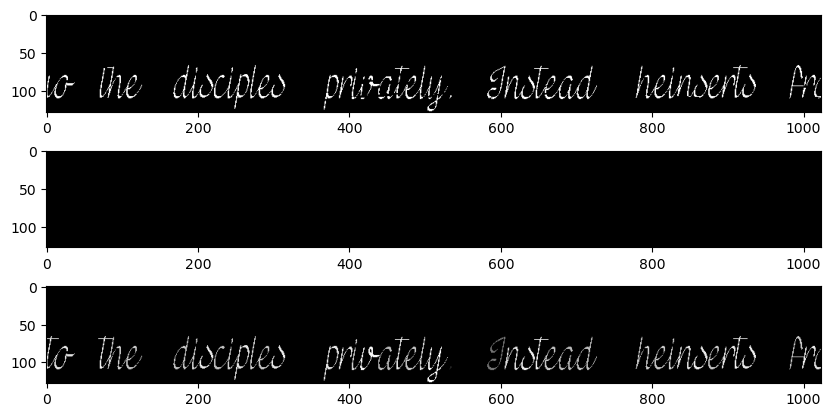

In [5]:

# example
choice = random.choice(train_metadata)
output = train_transforms(choice)
spatial_size = torch.zeros(config["spatial_size"]).shape
assert output["img"][0].shape == spatial_size or print(output["img"][0].shape, spatial_size)
assert output["seg"][0].shape == spatial_size or print(output["seg"][0].shape, spatial_size)
# ensuer seg is at max n_classes
assert output["seg"].max() < n_classes or print("wrong seg max", output["seg"].max())
assert output["seg"].min() >= 0 or print("wrong seg min", output["seg"].min())
assert output["img"].max() <= 1 or print("wrong img max", output["img"].max())
assert output["img"].min() >= 0 or print("wrong img min", output["img"].min())
assert output["img"].shape[0] == 2 or print(output["img"].shape)
assert output["seg"].shape[0] == 1 or print(output["seg"].shape)

 
print("image:", output["img"].shape)
print("segmentation:", output["seg"].shape)
print(f"range(img): ({output['img'].min()}, {output['img'].max()})")
print(f"range(img[1]): ({output['img'][1].min()}, {output['img'][1].max()})")
print(f"range(seg): ({output['seg'].min()}, {output['seg'].max()})")
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].imshow(output["img"][0], cmap="gray")
ax[1].imshow(output["img"][1], cmap="gray")
ax[2].imshow(output["seg"][0], cmap="gray")
plt.show()

In [6]:
train_dataset = CacheDataset(data=train_metadata, transform=train_transforms)
validation_dataset = CacheDataset(data=validation_metadata, transform=validation_transforms)
test_dataset = Dataset(data=test_metadata, transform=input_transforms)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"])
validation_loader = DataLoader(validation_dataset, batch_size=config["batch_size"])
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])

Loading dataset: 100%|██████████| 2114/2114 [00:00<00:00, 2114153.23it/s]


In [10]:

from modules.segnet import SEGNET
from monai.networks.nets import UNETR

print("device name", torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model_output_name = config.get("model_output_name")

hidden_size = 768
model = UNETR(
    in_channels=2,
    out_channels=n_classes, 
    img_size=config["spatial_size"],
    feature_size=32,
    num_heads=12,
    hidden_size=hidden_size,
    mlp_dim=4*hidden_size,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1,
    spatial_dims=2,
    conv_block=False
).to(device)

net = SEGNET(
    model_name=model_output_name,
    device=device, 
    load=False,
    model=model,
    img_size=config["spatial_size"],
    n_classes=n_classes,
)

pre_trained_model = config.get("pretrained_model", None)
if pre_trained_model:
    try:
        print("loading model")
        net.load_model("models/" + pre_trained_model)
        print("model loaded", pre_trained_model)
    except:
        print("could not load model")

# print number of trainable parameters
print("number of trainable parameters in millions:", sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000)
print("model size (MB)", sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024 / 1024)

device name NVIDIA GeForce RTX 3090
loading model
model loaded seglm-masked-v2-128x1024-iam.pt
number of trainable parameters in millions: 90.785727
model size (MB) 346.32006454467773


example batch shape torch.Size([12, 2, 128, 1024])
example batch gt shape torch.Size([12, 128, 1024])
output shape (12, 128, 1024)


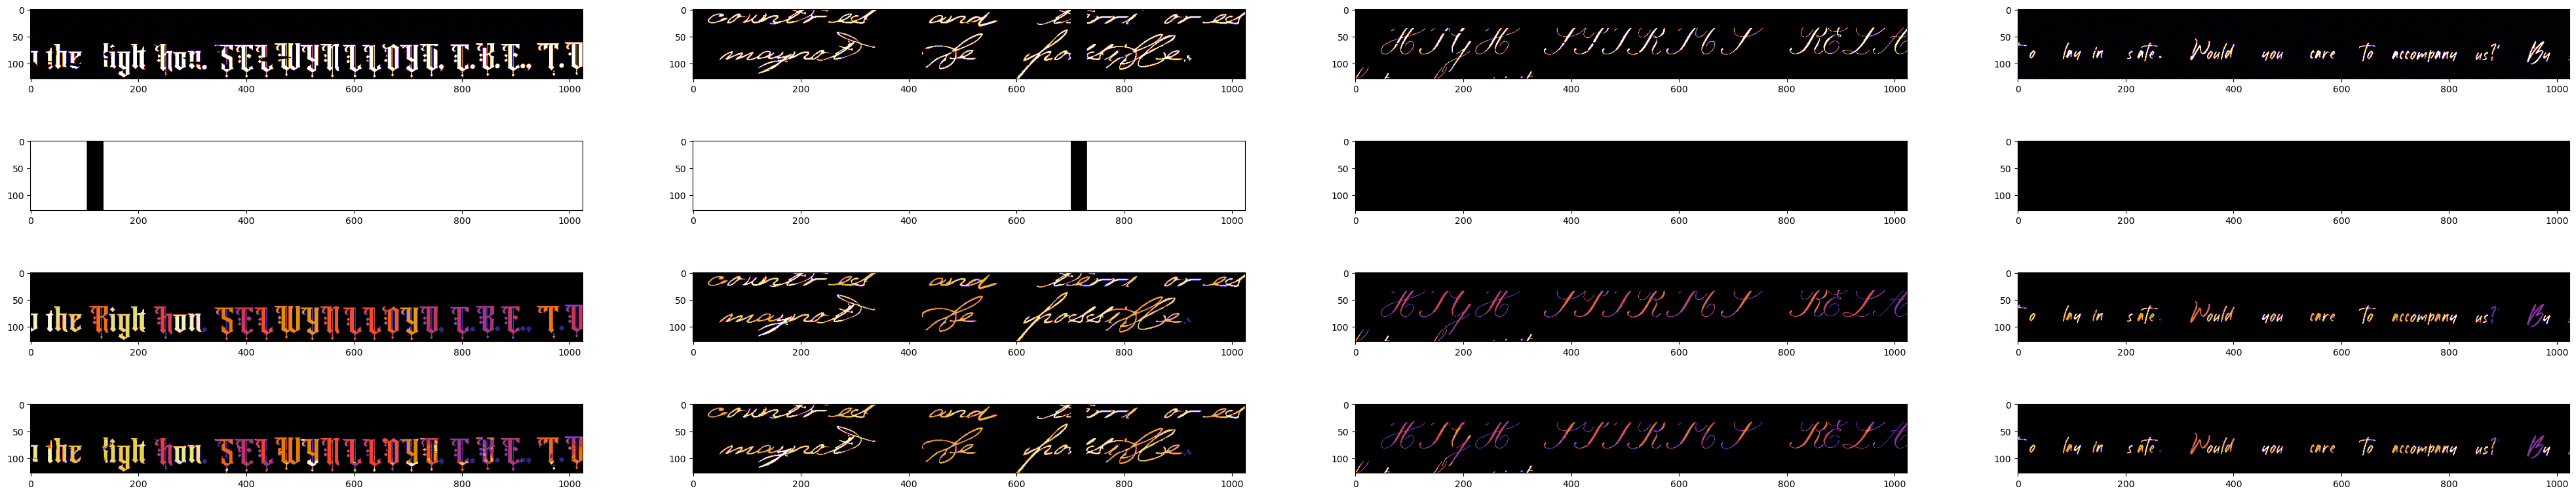

In [26]:
# take a rnaomd batch
example_batch = next(iter(train_loader))
example_batch_gt = example_batch["seg"].to(device).squeeze(1)
example_batch = example_batch["img"].to(device)

print("example batch shape", example_batch.shape)
print("example batch gt shape", example_batch_gt.shape)

with torch.no_grad():
    output = model(example_batch)
    output = torch.argmax(output, dim=-3)
    output = output.cpu().numpy()
print("output shape", output.shape)

# plot the first 4 input images and the reconstructed images
scale = 5
fig, ax = plt.subplots(4, 4, figsize=(10 * scale, 2 * scale))
for i in range(4):
    ax[0, i].imshow(example_batch[i][0].cpu(), cmap="CMRmap")
    ax[1, i].imshow(example_batch[i][1].cpu(), cmap="gray")
    ax[2, i].imshow(example_batch_gt[i].cpu(), cmap="CMRmap")
    ax[-1, i].imshow(output[i], cmap="CMRmap")
plt.show()

# save to ./figures/example-iam-<randomint>.pdf without margins
fig.savefig(f"figures/example-iam-{np.random.randint(0, 100)}.pdf", bbox_inches="tight", pad_inches=0)